# Lab 05

In this lab we will cover the process of sampling data points and interpolating additional points from those samples. We will then use what we have learned in the class to perform numerical simulations.


## Sampling

In a numerical application we typically do not have access to the underlying function $f(x)$ that we are modelling, but instead we have some discrete set of measurements, or samples, which we will call f[i]. Note that we will use math-mode and parenthesis for the original function and text-mode along with square brackets for the discrete samples. We can view the sampled function f[] as a list or array of $N$ sampled datapoints from $f()$. If we take $N$ evenly spaced samples from $f(start)$ to $f(end)$ then we can relate the two functions as: 

f[i] = $f(ih+start)$

Where $i \in [0,N-1]$ and $h = (end-start)/N$ is the spacing of the data points on a regular grid. 

Alternatively, we could have the case where the spacing between each data point is an irregular grid. I.e. we have

f[i] = $f(X[i])$

Where the function $X[i]$ takes an index $i \in [0,N-1]$ and provides a position $x$ for the location of the sampled point. The function $X[i]$ can be viewed as a list of locations for the values at $f[i]$. In the following snippet we illustrate sampling on a regular and irregular grid.




In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline


# QUESTION: What are the inputs of this function?
# QUESTION: What is the output of this function?
# QUESTION: What is this function doing?
def sample_f_on_regular_grid(f,num_points,start,end):
    h = (end - start)/num_points
    sampled_f = np.zeros(num_points)
    XI = [i*h+start for i in range(0,num_points)]
    for i in range(0,num_points):
        sampled_f[i] = f(XI[i])
        
    return [XI, sampled_f]


# This function samples f(x) by dividing the x dimension into
# num_points^2 values and sampling num_points number of points
# from it.
def sample_f_on_irregular_grid(f,num_points,start,end):
    # We need an integer range of points to sample from
    max_sample_range = num_points**2
    h = (end - start)/max_sample_range

    # QUESTION: What is this line of code doing?
    XI_not_scaled = sorted(random.sample(range(0, max_sample_range), num_points))
    # QUESTION: This is odd notation "[ g(i) for i in list()]", what is going on here?
    XI = np.array([ xi*h+start for xi in XI_not_scaled])
    
    sampled_f = np.zeros(num_points)
    for i in range(0,num_points):
        sampled_f[i] = f(XI[i])
    
    return [XI, sampled_f]


# QUESTION: What does linspace do?
ref_x = np.linspace(-4,4,1024)
ref_f = np.sin
#ref_f = lambda x: 1/(1+x**2)

[reg_xi, reg_f] = sample_f_on_regular_grid(ref_f,15,-4,4)
[irreg_xi, irreg_f] = sample_f_on_irregular_grid(ref_f,15,-4,4)

plt.plot(ref_x,ref_f(ref_x),label="original function")
plt.plot(reg_xi,reg_f,"-o",label="regular sampling")
plt.plot(irreg_xi,irreg_f,"-x",label='irregular sampling')

plt.legend()
plt.show()


### Hands on Activity
Work through the previous code snippet and examine the generated plot.

1. What is ref_f in the previous example and when would we, or would we even, have access to it? 
- Answer the questions embedded in the comments.
- When would an irregular sampling approach be preferable to a regular sampling? What abou the reverse?
- Modify the code and replace the reference function (np.sin) with 1/(1+x^2). What can we say about the plot?


### Hands on Activity
The code snippet above is a toy example of sampling over a function that we already know. In reality the sampling would be part of some external measurement. In this activity I want you to look at a real world example of sampling in audio signals. The scipy module provides resources for importing WAV files. Modify the code to accept MP3 files, see:
https://stackoverflow.com/questions/53633177/how-to-read-a-mp3-audio-file-into-a-numpy-array-save-a-numpy-array-to-mp3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
import math
%matplotlib inline

[rate, data] = scipy.io.wavfile.read('mandms.wav')

print("Sampling Rate: "+str(rate)+ " samples per second")

x = range(0,len(data))

# QUESTION: How does this compare to code we have already seen?
plt.plot(x, data)



## Interpolation

While sampling provides us with a proxy for our function of interest it may not provide the datapoints at the locations that we need. For example if we are using a small number of temperature probes to collect temperature samples on a metal rod and we want to simulate at a finer detail based on those measurements then we would need to use interpolation to provide us with those extra points needed for the detail.

In the following code example we implement two functions for interpolating points based on sampled data. This method does so by creating a piecewise function of linear approximation between every adjacent pair of samples. We can describe this as follows:

$ f_{interp}(c) =
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      \frac{f(a_1)-f(a_0)}{a_1-a_0}(c-a_0)+f(a_0) & a_0 \leq c \le a_1 \\
      \frac{f(a_2)-f(a_1)}{a_2-a_1}(c-a_1)+f(a_1) & a_1 \leq c \le a_2 \\
      \ldots \\
      \frac{f(a_{i})-f(a_{i-1})}{a_{i}-a_{i-1}}(c-a_{i-1})+f(a_{i-1}) & a_{i-1} \leq c \le a_{i}
      \ldots \\
      \frac{f(a_{n-1})-f(a_{n-2})}{a_{n-1}-a_{n-2}}(c-a_{n-2})+f(a_{n-2}) & a_{n-2} \leq c \le a_{n-1}
    \end{array}
\end{array}$

In the code we provide two functions, one that does the interpolation for a single point $c$ and a second that returns a new NumPy array of interpolated values.

In [ ]:
# NOTE: The demonstration requires that the sampling code cell be run first. 

import numpy as np
# this is going to be an example of the direct method

def interpolated_piecewise_from_sampled_regular_grid(c,f_samp,xi,num_points,start,end):
    h = (end-start)/num_points
    # find the points to the left and right of c
    # QUESTION: Why are we doing a min and max?
    a_ind = max(int(np.floor((c-start)/h)),0)
    b_ind = min(int(np.ceil((c-start)/h)),num_points-1)
    a = xi[a_ind]
    b = xi[b_ind]
    f_a = f_samp[a_ind]
    f_b = f_samp[b_ind]
    
    # QUESTION: Why are we doing this check?
    if f_b == f_a:
        return f_a
    else:
        # QUESTION: What is this formula?
        return ((f_b-f_a)/(b-a))*(c-a) + f_a

def interpolate_func_piecewise_from_sampled_regular_grid(new_num_points,f_samp,xi,num_points,start,end):
    new_h = (end - start)/new_num_points
    new_XI = [i*new_h+start for i in range(0,new_num_points)]

    interpolated_f = np.zeros(new_num_points)
    for i in range(0,new_num_points):
        interpolated_f[i] = interpolated_piecewise_from_sampled_regular_grid(new_XI[i],f_samp,xi,num_points,start,end)

    return [new_XI, interpolated_f]

###############
# HANDS ON: Interpolating on an irregular grid
# TODO: Implement the previous two functions but for irregular grids
###############
def interpolated_piecewise_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolate_func_piecewise_from_sampled_regular_grid(new_num_points,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS


#############
# HANDS ON: INTERPOLATION METHODS
# TODO: Pick 2 methods of your choosing
#       In the case where there are additional parameters to set you can set them as constant values.
#############
def interpolated_newtons_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolated_direct_method_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolated_hermite_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolated_berkhoff_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS

def interpolate_func_newtons_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolate_func_direct_method_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolate_func_hermite_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS
def interpolate_func_berkhoff_from_sampled_irregular_grid(c,f_samp,xi,num_points,start,end):
    pass # TODO: IMPLEMENT THIS


# NOTE: These are knobs to play with
start_x = -4
end_x = 4
num_of_sampled_points = 15
# QUESTION: What happens when we change this?
num_of_interpolated_points = 6 * num_of_sampled_points

ref_x = np.linspace(start_x,end_x,1024)
# QUESTION: What happens when we change our reference function?
#ref_f = np.sin
ref_f = lambda x: 1/(1+x**2)

# QUESTION: What is this function call doing?
[sampled_xi, sampled_f] = sample_f_on_regular_grid(ref_f,
                                                   num_of_sampled_points,
                                                   start_x,
                                                   end_x)

# QUESTION: What is this function call doing?
[interp_xi, interp_f] = interpolate_func_piecewise_from_sampled_regular_grid(num_of_interpolated_points,
                                                                             sampled_f,
                                                                             sampled_xi,
                                                                             num_of_sampled_points,
                                                                             start_x,end_x)

plt.figure(0)
plt.plot(ref_x,ref_f(ref_x),label="original function")
plt.plot(sampled_xi,sampled_f,"-o",label="regular sampling")
plt.plot(interp_xi,interp_f,"-x",label="interpolated function")
plt.legend()
plt.show()


## Error plot
plt.figure(1)

# QUESTION: A lot of this weird "list comprehension" going on. What are we doing here
errors = [ np.abs(interp_f[i] - ref_f( interp_xi[i] ) ) for i in range(0,num_of_interpolated_points) ]

plt.plot(interp_xi,errors,"-x",label="errors from piecewise")
plt.legend()
plt.show()


### Hands on Activity
Review and answer the questions in the previous code snippet.


### Hands on Activity
In the previous Jupyter cell we provided the code for performing piecewise interpolation on a regular grid. We want you to extend this by implementing functions for interpolating on an irregular grid. 


Note that you will need a way of finding the closest indices in $XI[]$ to the values left and right of $c$. The trick described here should help: https://stackoverflow.com/questions/9706041/finding-index-of-an-item-closest-to-the-value-in-a-list-thats-not-entirely-sort



### Hands on Activity
In class we have covered a variety methods for interpolation. Pick two of the methods below and compare their error relative to piecewise sampling. What are the benefits and tradeoffs to these methods.

1. Newton's Divided Difference
2. Direct Method (called Vandermond in class) LaGrange Interpolation
3. Hermite Interpolation
4. Berkhoff Interpolation



## Putting it all together

In this course you have studied a variety of topics and in a typical numerical application for solving and evaluating differential equations you will come across all of these steps. For example you start with samples from a physical experiment and you want to simulate its behavior. To do this you set up a differential equation describing the studied phenomena and use the measured samples as your starting values. To evaluate this you would do two things, interpolate the points between those samples and express the differential equation in terms of finite difference over those interpolated values. This will give you enough to simulate your system, but it might not be enough to answer interesting questions about your problem. Suppose you want to determine when your simulation no longer changes, i.e its first derivative is zero, then you can use one of the many zero finding methods to find that solution.


## Modelling the Spread of a Disease

For this I highly recommend that you watch the 3Blue1Brown video on Covid-19.
https://www.youtube.com/watch?v=Kas0tIxDvrg

In this video they suggest a logistic function to model the behavior of the spread of a virus. This logistic function $f(x) = \frac{1}{1+e^{-x}}$, which has the characteristic that the derivative drastically decreases as the function gets closer to saturating its maximum value. Specifically, we have the differential equation $\frac{d}{dx}f(x) = (1-f(x))f(x)$. Given this differential equation we can set up and simulate its behavior using finite-difference and the first few samples of data, say $f(0)$ and $f(1)$. With this we can do the following

1. Start with differential equation that relates the function $f(x)$ with its derivative $\frac{d}{dx}f(x)$
2. We have two problems, we do not have $\frac{d}{dx}f(x)$ and we would like to find $f(x+1)$ given only the previous values $f(x), f(x-1), f(x-2) \dots$. So we express $\frac{d}{dx}f(x)$ in terms of $f$ in a way that exposes $f(x+1)$
3. One possible expansion could be $(f[x+1]-f[x-1]))/2h = f[x](1-f[x])$.
4. Rewriting in terms of $f[x+1]$ we get $f[x+1] = 2h*f[x](1-f[x]) + f[x-1] $
5. We can loop over this expression to compute all values of $f[x+1]$ using only the previous values.

We can express this in code in the following snippet:

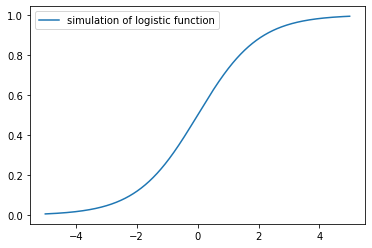

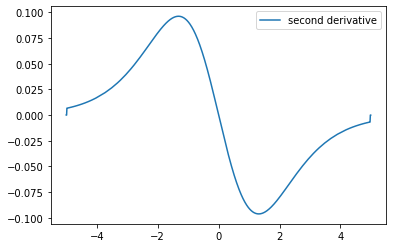

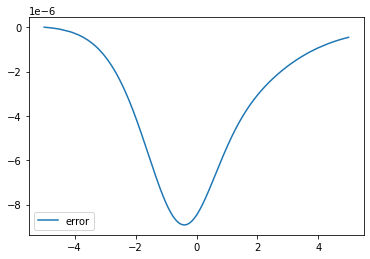

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def f(t):
    return 1.0/(1+ np.exp(-t))


# This is our interval
h = .01
start = -5
stop  = 5
num_points = int((stop - start)/h)
x = np.linspace(-5,5,num_points,endpoint=False)
xi = range(0,num_points)


####################
# BEGIN SIMULATION #
####################
# (d/dx)f(x) = f(x)(1-f(x))
# (f[x+1]-f[x-1]))/2h = f[x](1-f[x])
# f[x+1] = 2h*f[x](1-f[x]) + f[x-1] 

sim_num_points = num_points
sim_f_data = np.zeros( sim_num_points )

# These are our starting samples
sim_f_data[0] = f(0*h-5)
sim_f_data[1] = f(1*h-5)
#sim_f_data[2] = f(2*h-5)  # What if we need more starting values 
#sim_f_data[3] = f(3*h-5)
#sim_f_data[...] = f(...*h-5)



# This is the simulation using our finite difference equations
for i in range(1,sim_num_points-1):
    sim_f_data[i+1] = 2*h*sim_f_data[i]*(1-sim_f_data[i]) + sim_f_data[i-1]

    
####################
## END SIMULATION ##
####################    

# Let's compute the second derivative really quickly:
# http://web.media.mit.edu/~crtaylor/calculator.html
sim_fxx_data = np.zeros( sim_num_points )
for i in range(2,sim_num_points-2):
	sim_fxx_data[i] = (1*sim_f_data[i-1]-2*sim_f_data[i+0]+1*sim_f_data[i+1])/(1*1.0*h**2)
	


plt.figure(0)
plt.plot(x,sim_f_data, label="simulation of logistic function")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(x,sim_fxx_data, label="second derivative")
plt.legend()
plt.show()


plt.figure(2)
plt.plot(x,sim_f_data-f(x), label="error")
plt.legend()
plt.show()



## Hands on Activity
Using the zero finding algorithms that we studied in previous labs can you find the inflection point? i.e. $f^{''}(x)=0$


## Hands on Activity
Using all of the techniques studied in this class can you reduce the error reported by the estimation?



## Exploring Simulations

In lieu of online judge problems we want you to explore how numerical applies to other domains. Check out these links and try to get their example code running.

1. Electrostatics
https://github.com/tomduck/electrostatics
2. Acoustics
https://pypi.org/project/pyroomacoustics/
3. Computer Graphics
https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing

## Additional Reading
Check out this interesting tutorial on Neural Networks: http://neuralnetworksanddeeplearning.com/chap1.html
